### Implementation
* Move to Python3
* Git hub update
* Load Pierre protein list
* Check for exisiting path between any node and a seed node after edge trimming
* Remove network not connected with seed node 

### Study
$\Delta$ SimPct treshold

 * How many networks
 * Tabulate individual protein degree across the generated networks

| Protein| 80% | 60% | ... | 10% |
| ------ | --- | --- | --- | --- |
| XXX    | 22  | 10  | ... | NA  |



GO analysis:
* Global tablechart of GO terms occurences across the network
* For given Protein and its 1st neighbors, display the GO annotations distribution of the proteins and their templates

TODO 

  1. Récuperer interaction experiemntals suplémentaires
  2. Alignement de séquences sur protéines du divisome
  3. Définition de blocs
  4. Métrique homologie basée sur la similarité dans ces blocs.



In [1]:
import sys
import os
import subprocess
sys.path.append('/Users/guillaumelaunay/work/projects/pneumocoque/omegaLoMo/lib')
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteinsExt/src")
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteins/src")

%load_ext autoreload

In [2]:
import pandas
import json

def loadSeedList(lType='all'):
    rootDir='/Users/guillaumelaunay/work/projects/pneumocoque/lists'
    fileMap = {
        'phino' : 'DivAlreadyKnow_litt_phino.txt',
        'massida' : 'DivAlreadyKnow_litt_massida.txt',
        'barletMerge': 'divKnownR6.txt',
        'garcia' : 'pierre_uniprot_DL.tsv',
        'all' : 'current_merge.txt'
    }
    if lType not in fileMap:
        raise IndexError("no set named " + lType)
        
    pFrame = pandas.read_csv( rootDir + '/' + fileMap[lType], sep='\t', lineterminator='\n')
    return [ uniprotID for uniprotID in pFrame.loc[:]["Entry"] ]



* MITAB_file and filterIds can be filled when reading serialized data, or read from scratch, using input files.
* MITAB_file contains IntAct informations, restricted to physical interactions. 
It is a subset of the informations
from /mobi/group/divisome/physical_intact.mitab.txt, after serialization by an external python script.
* filterIds contains information about S pneumoniae
* intactR6filtered_topology is a dictionary, with pairs of UniProt Ids of proteins from IntAct interactions, that match with R6 sequences,
non redundant.

## Combining experimental evidences and homology relationship

### $I^{st}$ input *psicquic.MitabTopology* object

##### Previously pickled psicquic.MitabTopology object (see R6 topology notebook)

It can be viewed as a tree representation of an adjacency matrix
with non-zero cell elements storing list of mitab experimental evidences.

The actual data structure is a 2 level dictionnary of uniprotID keys referencing list of mitab informations


```json
{
    psicquicInteractorID : {
        psicquicInteractorID : [ psqDataObject , ...]
    }
    
}

```

API description

In [3]:
import pickle
#mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.H50.mitabToplogy.pickle"
mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.mitabToplogy.pickle"
mitabTopologyObject = None
with open(mitabTopologyPickle, 'rb') as fP:
    mitabTopologyObject = pickle.load(fP)
print("Number of interaction unpickled", len(mitabTopologyObject) )

Number of interaction unpickled 54993


In [4]:
mitabTopologyObject["P38801"]["P24783"]

[uniprotkb:P24783	uniprotkb:P38801	intact:EBI-5602|uniprotkb:Q05456|uniprotkb:D6W169	intact:EBI-1909|uniprotkb:D3DL32	psi-mi:dbp2_yeast(display_long)|uniprotkb:DBP2(gene name)|psi-mi:DBP2(display_short)|uniprotkb:YNL112W(locus name)|uniprotkb:N1945(orf name)|uniprotkb:DEAD box protein 2(gene name synonym)|uniprotkb:p68-like protein(gene name synonym)	psi-mi:lrp1_yeast(display_long)|uniprotkb:LRP1(gene name)|psi-mi:LRP1(display_short)|uniprotkb:Like an rRNA processing protein 1(gene name synonym)|uniprotkb:rRNA processing protein 47(gene name synonym)|uniprotkb:RRP47(gene name synonym)|uniprotkb:YC1D(gene name synonym)|uniprotkb:Yeast C1D domain-containing protein(gene name synonym)|uniprotkb:YHR081W(locus name)	psi-mi:"MI:0111"(dihydrofolate reductase reconstruction)	Tarassov et al. (2008)	pubmed:18467557|mint:MINT-6673767|imex:IM-14275	taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)	taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)	psi-mi:"MI:0915"(physical associa

### $II^{nd}$ input *homology tree-like* document

Two level tree storing homology relationship between psicquic entries (**PSQ**) (primary keys) and
target proteome (**TP**) entries (secondary keys)
Leaves are array which contains one tuple per HSP (currently only one HSP)
HSP informations are

 **TP** sequence Length**,** **TP**_hsp start position**,** **TP**_hsp stop position**,** **PSQ**_sequence Length**,** **PSQ**_hsp start position**,** **PSQ**_hsp stop position**,** HSP positive match number**,** HSP identical match number**,** HSP eValue

```json
{
"P97760": {"P66709": [["311", "5", "235", "275", "5", "272", "95", "45", "4.79675e-27"]]},
"P98084": {"Q59947": [["1963", "262", "811", "750", "24", "572", "176", "95", "2.1715e-07"]], "Q8DQN5": [["1876", "191", "395", "750", "52", "281", "75", "47", "1.90067e-06"]]},
}
```


In [4]:
homologyFile="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_R6_homology.json"

## Building network Topology  TO REVISED


##### **buildEdges ** 
Performs the homolog expansion

**args**:None

##### **resetEdges** 
Any network can be reverted to the state obtained at **buildEdge** completion

**args**:None
##### **trimEdges**
Discard homology relationship violating treshold-based constraints.
An edge without remaining homology relationship is removed

**args**: optional,named
 * idPct
 * simPct
 * cvPct
 
##### **nodes**
A dictionary attribute with network node and their supporting PSQ protein. 
```
{
    node_UniprotID : { PSQ_uniprotID, ... }
}
```



In [44]:
%autoreload 2


import omega

In [177]:
om = omega.omegaTopology(mitabTopologyObject, homologyFile)
om.buildEdges()

seedList=loadSeedList()


def trimPruneTest(omegaObj, idPct, _seedList):
    print("Current number of edges " + str(om.edgeNumber) )
    om.trimEdges(idPct=idPct)
    print(str(om.edgeNumber) + ' edges after triming' )
    G=om.prune(*_seedList)
    print(str(om.edgeNumber) + ' edges after pruning' )
    return G


84127  interactions unpacked from  54993


In [66]:
trimPruneTest(om, 10.00, seedList)

Current number of edges 84127
1100  interactions trimmed from total  84127
83027 edges after triming
83011 edges after pruning


In [69]:
G=trimPruneTest(om, 40.00, seedList)

Current number of edges 26611
83075  interactions trimmed from total  84127
1052 edges after triming
1004 edges after pruning


In [71]:
om.jupyterNodeView()

Q8DNC3,142
P0A336,43
Q8CWT3,39
Q8CWN9,36
Q8DPS0,34
Q8DRQ3,33
P59661,30
Q8DQN2,26
Q8DQD4,25
P63788,22
Q8DQL1,22


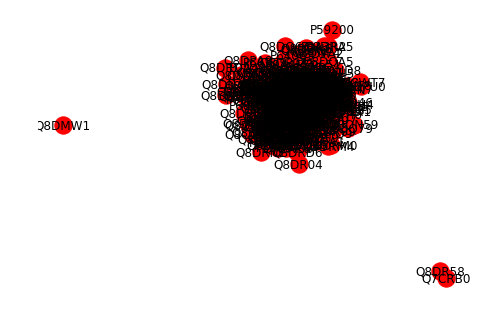

In [72]:
nx.draw(G, with_labels=True)

In [68]:
trimPruneTest(om, 20.00, seedList)

Current number of edges 1004
57493  interactions trimmed from total  84127
26634 edges after triming
26611 edges after pruning


In [164]:
for n in nx.degree(G):
    print(n[0])

Q8DNW6
Q8DQD4
Q8DQF8
Q8DQV2
Q8DQI3
Q8CWT3
P63788
Q8DPZ0
Q8DNC3
Q8DRF9
Q8DP77
Q8DQL1
Q8DQR5
Q8DP49
Q8DPK4
Q8DNJ8
Q8DQ60
P0A336
P66041
P65537
Q8DPS0
Q8DQG9
Q8DPT3
P67319
Q8DRD7
Q8DPC2
Q8DR13
P0A4D8
Q8DQT0
Q8CWV5
Q8DPK2
Q8DPH1
Q8DQH0
Q8DNL9
Q8DNJ6
Q8CWS1
P65240
P65242
Q8DRB0
Q8CWT6
Q8DPK7
Q8DP05
Q8DR34
P66921
Q8DR03
Q8CWN6
P63545
P0A4S2
P64031
Q8CWS9
Q8DQ29
Q8DPG0
Q8DP35
Q8CYJ1
Q8DR82
Q8CWR0
Q8CWS5
Q8DPM6
P65444
P63734
Q8CZE9
Q7CRB7
P64298
Q7CRB8
Q8DR11
Q8CWS2
Q8DRQ3
Q8DQ55
Q8DQ68
Q8DRM7
Q8DRB3
P59659
Q8CWT4
Q8CWT2
P65947
P0A2W7
Q8DQL6
P65888
Q8DPU5
Q8CWN9
Q8DNI9
P65145
Q8DP45
Q8DR04
Q8DR05
Q8DRH7
Q8DQG0
Q8DQI7
P65509
P63589
P59661
P66340
Q8DNM8
Q8DNX8
Q8DR22
Q8DQD3
Q8CWQ4
Q8CWV0
Q8DNU5
Q8DQU7
Q8DQ79
P64023
Q8CWS6
Q8CWT1
Q8DPN5
Q8DQD7
Q8CWU8
Q8CWQ0
P67581
Q8DQX8
Q8CWV3
Q8DQ00
Q8DQ84
P66360
Q8DR29
Q8DR64
Q8DRF8
Q8DMY8
Q8CWV9
Q8DQA2
Q8DPQ4
P0A476
Q8DQN2
Q8CWU4
P63385
P66096
Q7CRB1
Q8DPL3
Q8DP44
Q8DRI0
Q8DNM6
Q8DRD4
Q7ZAK7
Q8DPZ9
Q8DR10
P0A4T0
Q9EUQ7
Q8DPE0
P67050
P59655
Q8CWQ7
Q8DN69
Q8DQT8

## Node template assignment robustness to similarity treshold

Ploting following datastructure which represents the degree as a function of an edge triming parameter (eg: identity)

```python
([60, 65, 70, 75, 80, 85, 90, 95, 100],
 {'P0A2W7': [7, 7, 7, 7, 7, 7, 7, 6, 0],
  'P0A336': [6, 2, 2, 2, 2, 2, 2, 2, 0],
  'P0A496': [1, 0, 0, 0, 0, 0, 0, 0, 0],
  'P0A4A8': [2, 0, 0, 0, 0, 0, 0, 0, 0],
  'P0A4B6': [1, 0, 0, 0, 0, 0, 0, 0, 0],
  'P0A4J7': [5, 5, 5, 5, 5, 5, 5, 5, 0]
  })
 ``` 

In [149]:
import matplotlib.pyplot as plt

In [173]:
def singleLineChart(topologyObject, _seedList, idPctMin=10, step=5):
    x = []
    d = {}
    
    for idPct in range(idPctMin, 100 + step, step):
        x.append(idPct)
        G = trimPruneTest(topologyObject, idPct, _seedList)
        if not d:
            for n in nx.degree(G):
                d[n[0]] = []
        for k in d:
            d[k].append(0)
            
        for n in nx.degree(G):
             d[n[0]][-1] = n[1]
    return (x, d)

In [182]:
data = singleLineChart(om, seedList, idPctMin=30, step=2)

Current number of edges 21
79910  interactions trimmed from total  84127
4217 edges after triming
4118 edges after pruning
Current number of edges 4118
80879  interactions trimmed from total  84127
3248 edges after triming
3174 edges after pruning
Current number of edges 3174
81663  interactions trimmed from total  84127
2464 edges after triming
2414 edges after pruning
Current number of edges 2414
82298  interactions trimmed from total  84127
1829 edges after triming
1785 edges after pruning
Current number of edges 1785
82691  interactions trimmed from total  84127
1436 edges after triming
1394 edges after pruning
Current number of edges 1394
83051  interactions trimmed from total  84127
1076 edges after triming
1028 edges after pruning
Current number of edges 1028
83248  interactions trimmed from total  84127
879 edges after triming
831 edges after pruning
Current number of edges 831
83410  interactions trimmed from total  84127
717 edges after triming
678 edges after pruning
Current

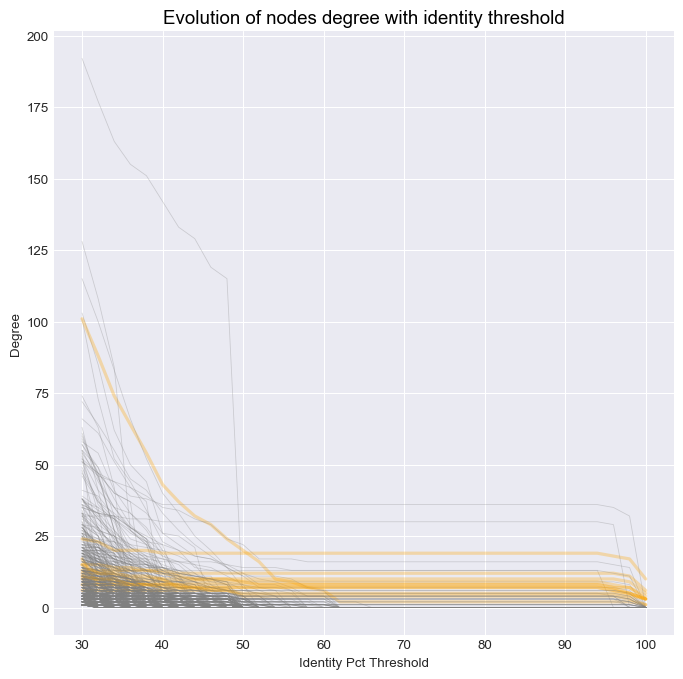

In [189]:
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)


plt.title("Evolution of nodes degree with identity threshold", loc='center', fontsize=14, fontweight=4, color='black')
plt.xlabel("Identity Pct Threshold")
plt.ylabel("Degree")



for name in data[1]:
    c = 'grey' if data[1][name][-1] == 0 else 'orange'
    w =  0.6 if data[1][name][-1] == 0 else 2.4
    plt.plot(data[0],data[1][name], marker='', color=c, linewidth=w, alpha=0.3)
#plt.plot([0,2,4],[0,2,4], marker='', color='blue', linewidth=0.6, alpha=0.3)


## Enriching network

### Building supporting uniprot collection

In [84]:
import pyproteinsExt.uniprot as uniprot
from pyproteinsExt.uniprot import EntryEncoder


uColl = uniprot.getUniprotCollection()
uColl.setCache(location='/Users/guillaumelaunay/work/data/uniprot')
uniprot.proxySetting(https="http://ftprox.ibcp.fr:3128", http="http://ftprox.ibcp.fr:3128")

Acknowledged 0 entries (/Users/guillaumelaunay)
Changing cache location to /Users/guillaumelaunay/work/data/uniprot
Reindexing /Users/guillaumelaunay/work/data/uniprot
Acknowledged 11306 entries (/Users/guillaumelaunay/work/data/uniprot)
!!Proxy set to {'https': 'http://ftprox.ibcp.fr:3128', 'http': 'http://ftprox.ibcp.fr:3128'}


In [73]:
om.nodes

{'P0A2W7': {'P0A2W6', 'P96618'},
 'P0A2Y7': {'P31104'},
 'P0A336': {'O69289',
  'P0A335',
  'P0A6F5',
  'P10809',
  'P19882',
  'P42383',
  'P78012',
  'Q05972',
  'Q9VPS5',
  'Q9ZN50'},
 'P0A3B8': {'P80700'},
 'P0A3R0': {'O25011', 'P0A746'},
 'P0A3R2': {'P49850'},
 'P0A3Y4': {'P00950', 'P07738', 'P15259', 'P16290', 'P18669'},
 'P0A452': {'P16971', 'Q0P7V6'},
 'P0A472': {'O83268', 'P02394', 'P0A7K2', 'P36210', 'Q9PI32'},
 'P0A476': {'P41204', 'P56041', 'Q9PLX8'},
 'P0A484': {'Q50310'},
 'P0A496': {'O83239', 'P0A7Q6', 'P52864'},
 'P0A4A8': {'P17293', 'P53732', 'P75546'},
 'P0A4B4': {'Q03246', 'Q50309', 'Q9PLY0'},
 'P0A4B6': {'P0A7U3', 'P21476', 'P75576'},
 'P0A4C4': {'P21465', 'P41205', 'P73314'},
 'P0A4D8': {'O25029', 'P0A8J8', 'P96614'},
 'P0A4J0': {'P00579', 'P06224', 'P55993', 'P74565', 'Q59996'},
 'P0A4J7': {'P04179', 'P0A4J6', 'P0AGD3', 'P54375', 'Q0PBW9'},
 'P0A4M0': {'P0AES6', 'P22447', 'P55992', 'P77966', 'P78016'},
 'P0A4M6': {'O25151', 'P0A862', 'P80864', 'Q9PPE0', 'Q9ZKE7'},

In [143]:
# Create a collection of all uniprot entities in a network
class NetworkUniprotCollection:
    def __init__(self, omegaTopologyObject, uniprotMainCollection):
        self.networkUP = {}
        self.upDic = omegaTopologyObject.nodes
        for n in self.upDic:
            l = [n] + list(self.upDic[n])
            for x in l:
                if x not in self.networkUP:
                    self.networkUP[x] = uniprotMainCollection.get(x)
        # write to FS if fetched were performed
        uniprotMainCollection.serialize()
        print("loaded" + str(len(self)) + ' uniprot entries')
    
    def __len__(self):
        return len(self.networkUP)
    
    def GOview(self):
        goChart = uniprot.keyWordChart([ self.networkUP[x] for x in self.networkUP ])

        return htmlTable([ ( x[0], len(x[1]) ) for x in goChart ], ['GO term', 'Occurence'])

class htmlTable:
    def __init__(self, data, headers):
        self.data = data
        self.headers = headers
    def _repr_html_(self):
        htmlString = '<table><thead><th>' + '</th><th>'.join(self.headers) + '</th></thead><tbody>'
        for datum in self.data:
            htmlString += '<tr><td>' + '</td><td>'.join([ str(d) for d in datum ]) + '</td></tr>'

        htmlString += '</tbody></table>'

        return htmlString



In [144]:
netUniColl = NetworkUniprotCollection(om, uColl)
uniprotJsonString = json.dumps({"registry" : netUniColl.networkUP },  cls=EntryEncoder)
#uniprotJsonString

serializing uniprot collection
0 entries updated, total pool is 11306
serializing pfam collection
0 entries updated, total pool is 11221
loaded1192 uniprot entries


In [10]:
tag="uniprot_id40NTW"

jsonBean = om.dump()

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".json", "w") as fp:
    fp.write(str(jsonBean).replace("\'", "\"")[:-1] + ", " + uniprotJsonString[1:] )

### Building supporting mitab collection

* Filtering _mitabObject_ for pair of template founds in the network
* write a mitab formated file of the filtered interactions

In [19]:
tColl = om.templateZipPair()
mitabTopologyObject.autoAppendable=True
mitabAsStr = ''
for t1, t2, d in tColl:
     mitabAsStr +=  '\n'.join( [ str(psq) for psq in mitabTopologyObject[t1][t2] ] )

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".mitab", "w") as fp:
    fp.write(mitabAsStr)

## Miscellanous network properties


#### Go term distribution

In [146]:
netUniColl.GOview()

GO:0005737:C:cytoplasm{ECO:0000501},414
GO:0005524:F:ATP binding{ECO:0000501},404
GO:0005829:C:cytosol{ECO:0000318},316
GO:0006412:P:translation{ECO:0000501},138
GO:0003735:F:structural constituent of ribosome{ECO:0000318},133
GO:0046872:F:metal ion binding{ECO:0000501},122
GO:0000287:F:magnesium ion binding{ECO:0000501},106
GO:0003677:F:DNA binding{ECO:0000501},98
GO:0005886:C:plasma membrane{ECO:0000314},89
GO:0019843:F:rRNA binding{ECO:0000501},86
GO:0042802:F:identical protein binding{ECO:0000353},85


### Go Term analysis TO REWORK

 * Enriching a network in uniprot object
 * Returns a GO terms chart

In [109]:
(goScoreQ, goScoreT) = GOneighbouring(G, "P0A2W7")

6  Templates and  6  Queries uniprot entities to create
got to fetch Q8CWN9
got to fetch Q8CWN9
got to fetch P59661
got to fetch P59661
got to fetch Q8CWT4
got to fetch Q8CWT4
got to fetch Q8CWT2
got to fetch Q8CWT2
got to fetch Q8DRB3
got to fetch Q8DRB3
got to fetch Q97NV3
got to fetch Q97NV3
got to fetch P0A2W6
got to fetch P0A2W6
got to fetch Q97SE5
got to fetch Q97SE5
got to fetch Q97S73
got to fetch Q97S73
got to fetch P95830
got to fetch P95830
got to fetch Q97SR4
got to fetch Q97SR4


In [ ]:
def GoPick(G, nodeName):    
    nx.ego_graph(G, nodeName, radius)
    # list Each node template
    # Try to fetch GO term
    